<a href="https://colab.research.google.com/github/patison5/FAIntelligence/blob/main/%D0%93%D1%80%D0%B0%D0%B4%D0%B8%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B9_%D1%81%D0%BF%D1%83%D1%81%D0%BA_(%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9_%D0%BC%D0%B5%D0%BD%D0%B0%D1%8E%D1%89%D0%B8%D0%B9%D1%81%D1%8F_learning_rate__Adam).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Инициализация

In [1]:
import numpy as np

#### Инициализация лямба функций формулы П.3 из книжки Пантелеева

In [2]:
''' 
    Мультифункция (рис П.3)
    Глобальный экстремум Z = 837,9657 
'''

P4Multi = lambda v: v[0] * np.sin(4 * np.pi * v[0]) + v[1] * np.sin(4 * np.pi * v[1])
P4MultiGrad = lambda v: np.array([ 4 * np.pi * v[0] * np.cos(4 * np.pi * v[0]) + np.sin(4 * np.pi * v[0]), 4 * np.pi * v[1] * np.cos(4 * np.pi * v[1]) + np.sin(4 * np.pi * v[1]) ])


### Реализация классического градиентного спуска

In [3]:
def classic_gradient_descent(
    gradient, start, learn_rate, n_iter=250, eps=1e-06
):
    vector = start
    for _ in range(n_iter):
        diff = -learn_rate * gradient(vector)
        if np.all(np.abs(diff) <= eps):
            break
        vector += diff
    return vector

#### Тестирование классического градиентного спуска

Классический градиентный спуск <br>
Функция: у = 𝑣²<br>
Градиент: y = 2𝑣<br>

In [4]:
classic_gradient_descent(
  gradient=lambda v: 2 * v, start=10.0, learn_rate=0.2
)

2.210739197207331e-06

Классический градиентный спуск <br>
Функция: у = 𝑣⁴ - 5𝑣² - 3𝑣 <br>
Градиент: y = 4𝑣³ − 10𝑣 − 3 <br>

In [5]:
classic_gradient_descent(
  gradient=lambda v: 4 * v**3 - 10 * v - 3, start=0,
  learn_rate=0.2
)

-1.0136634890267242

Классический градиентный спуск для двух и более переменных<br>
Функция: у = 𝑣₁² + 𝑣₂⁴ <br>
Градиент: y = 2𝑣₁, 4𝑣₂³ <br>

In [6]:
classic_gradient_descent(
  gradient=lambda v: np.array([2 * v[0], 4 * v[1]**3]),
  start=np.array([1.0, 1.0]), learn_rate=0.2, eps=1e-08
)

array([3.44994837e-56, 4.84026715e-02])

Классический градиентный спуск для функции из книжки Пантелеева

In [7]:
classic_gradient_descent(
  gradient=P4MultiGrad,
  start=np.array([838., 9658.]), learn_rate=0.2, eps=1e-08
)

array([3.13210253e+28, 1.26018218e+23])

### Модификация градиентного спуска (меняющийся learning_rate)

In [8]:
def gradient_descent_mlr(
    gradient, start, learn_rate=0.2, n_iter=50, eps=1e-06
):
    vector = start
    for idx in range(n_iter):
        lr = learn_rate / min((1 + idx), 10)
        diff = -lr * gradient(vector)
        if np.all(np.abs(diff) <= eps):
            break

        # print(vector, lr, diff)
        vector += diff
    return vector

#### Тестирование модифицированного градиентного спуска

In [9]:
print(classic_gradient_descent(
  gradient=lambda v: 4 * v**3 - 10 * v - 3, start=0, learn_rate=0.1
))

print(gradient_descent_mlr(
  gradient=lambda v: 4 * v**3 - 10 * v - 3, start=0, learn_rate=0.3
))

1.2854013303966605
1.7139383192807744


### Алгоритм Adam

In [10]:
from math import sqrt
from numpy import asarray
from numpy import arange
from numpy.random import rand
from numpy.random import seed
from numpy import meshgrid
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

In [20]:
def f(x, y):
	return x**2.0 + y**2.0
 
def df(x, y):
	return asarray([x * 2.0, y * 2.0])
 
# def f(x, y):
# 	return 100*(y - x**2)**2 + (1 - x)**2
 
# def df(x, y):
# 	return asarray([-400*x*(-x**2 + y) + 2*x - 2, -200*x**2 + 200*y])

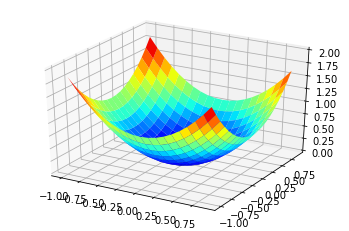

In [21]:
r_min, r_max = -1.0, 1.0

xaxis = arange(r_min, r_max, 0.1)
yaxis = arange(r_min, r_max, 0.1)

x, y = meshgrid(xaxis, yaxis)

results = f(x, y)

figure = pyplot.figure()
axis = figure.gca(projection='3d')
axis.plot_surface(x, y, results, cmap='jet')

pyplot.show()

In [24]:
def adam(f, df, bounds, n_iter, alpha, beta1, beta2, eps=1e-8):
	solutions = list()
 
	# Генерация стартовой точки
	x = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
	score = f(x[0], x[1])
 
	# инициализация момента и экспоненциально взвешенной нормы
	m = [0.0 for _ in range(bounds.shape[0])]
	v = [0.0 for _ in range(bounds.shape[0])]

	for t in range(n_iter):
    # Считаем градиент для текущего временного шага
		g = df(x[0], x[1])
  
		for i in range(bounds.shape[0]):
    
      # Обновление 1-го момента с использованием градиента и гиперпараметра betta1
			m[i] = beta1 * m[i] + (1.0 - beta1) * g[i]

      # Обновление 2-го момента с использованием градиента и гиперпараметра betta2
			v[i] = beta2 * v[i] + (1.0 - beta2) * g[i]**2

      # Исправление момента с учетом погрешности
			mhat = m[i] / (1.0 - beta1**(t+1))

      # Исправление момента с учетом погрешности
			vhat = v[i] / (1.0 - beta2**(t+1))
   
      # Вычисление параметра
			x[i] = x[i] - alpha * mhat / (sqrt(vhat) + eps)

    # Сохранение истории
		solutions.append(x.copy())

	return solutions


bounds = asarray([[-1.0, 1.0], [-1.0, 1.0]])
solutions = adam(f, df, bounds, 60, 0.02, 0.8, 0.999)

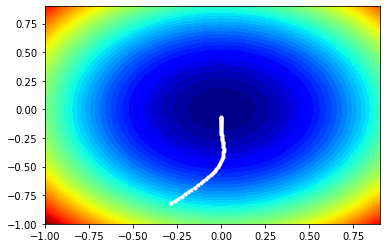

In [25]:
xaxis = arange(bounds[0,0], bounds[0,1], 0.1)
yaxis = arange(bounds[1,0], bounds[1,1], 0.1)

x, y = meshgrid(xaxis, yaxis)

results = f(x, y)

pyplot.contourf(x, y, results, levels=50, cmap='jet')

solutions = asarray(solutions)
pyplot.plot(solutions[:, 0], solutions[:, 1], '.-', color='w')

pyplot.show()